<a href="https://colab.research.google.com/github/sopyop/2023-NSERC-Solid-Electrolyte-Code-ST/blob/main/Moyles_NSERC_SE_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%pip install astropy

22.097082398637703
2.2969724011869177
0.9247678939234345
0.40352313921597677
0.1207996690058064
0.014244586600202282
0.00020706634796407433
4.0330217181610446e-08


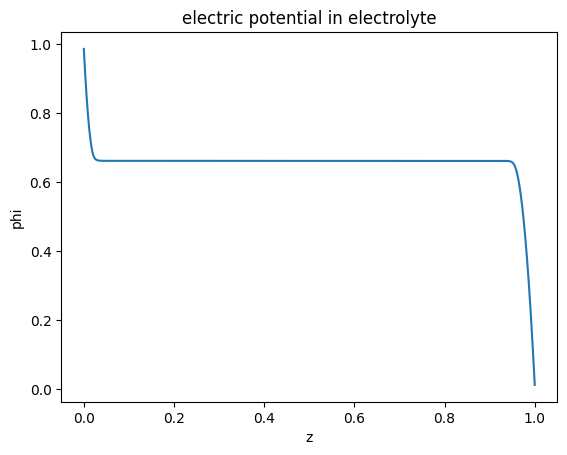

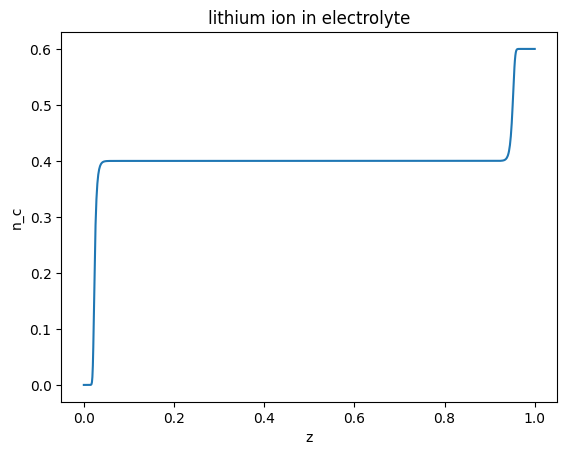

found solution after 8 iterations.
4.0330217181610446e-08


array([[  0.98695195],
       [  0.961895  ],
       [  0.9378772 ],
       ...,
       [106.75979434],
       [111.10780383],
       [  0.66662337]])

In [2]:
#@title
import numpy as np
import matplotlib.pyplot as plt
import astropy

N = 1000

v = 0.6
z_c = 1
z_a = -1
n_a = 0.4
delta = 1/170
ep = 0.0196

delta_z = 1/(N+1)
x_ax = np.linspace(0, 1, num=(N+1))


#will have finite diff, integral contstraint, and the constant c (_f, _r, _c)

#finite diff:

A_init = np.zeros((N+1, N+1))
A_0 = [-3, 1]
A_N = [1, -3]
A_init[0] = np.pad(A_0, (0, N-1))
A_init[N] = np.pad(A_N, (N-1, 0))

A_in = [1, -2, 1]
for i in range(N-1):
  A_init[i+1] = np.pad(A_in, (i, N-2-i))

A_f = delta_z**(-2) * (ep**2) * A_init

b_f = np.zeros((N+1, 1))
b_f[0] = ep**(2) * 2/((delta_z)**2)

def phi_2nd_f(theta):
  return ((z_c*v)/(1 + np.e**(-theta))) + z_a*n_a


#constant

A_c = np.zeros((N+1, N+1))
A_c_in = [z_c]
for i in range(N+1):
  A_c[i] = np.pad(A_c_in, (i, N-i))

def b_c(c):
  return np.full((N+1, 1), -c)                                               #assuming c will be given as a single number

def phi_2nd_c(theta):
  return delta*theta


#reimann sum of intergral constraint

A_r = np.zeros((1, N+1))
b_r = np.full((1,1), (z_a*n_a)/(z_c*v))
def phi_2nd_r(theta):
  return np.full((1,1), np.sum(delta_z * np.divide(1, (1+np.e**(-theta)))))                 #is the function being integrated summed


#final values for A, b, and phi_2nd

A = np.concatenate((A_f, A_c, A_r))
def b(c):
  return np.concatenate((b_f, b_c(c), b_r))
def phi_2nd(theta):
  return np.concatenate((phi_2nd_f(theta), phi_2nd_c(theta), phi_2nd_r(theta)))


#defining function and jacobian

def f(u):
  phi, theta, c = u[0:N+1], u[N+1:-1], float(u[-1])
  return np.matmul(A, phi) + b(c) + phi_2nd(theta)


def D(theta):
  D_f = np.zeros((N+1, N+1))
  for i in range(N+1):
    numer = z_c*v*np.e**(-theta[i])
    denom = (1 + np.e**(-theta[i]))**2
    D_f_in = numer/denom
    D_f[i] = np.pad(D_f_in, (i, N-i))

  D_c = np.zeros((N+1, N+1))
  D_c_in = [delta]
  for i in range(N+1):
    D_c[i] = np.pad(D_c_in, (i, N-i))

  #D_r = delta_z * np.ones((1, N+1))
  D_r = np.zeros((1, N+1))
  for i in range(N+1):
    D_r[0,i] = delta_z * (np.e**(-theta[i,0])/(1+np.e**(-theta[i,0]))**2)

  return np.concatenate((D_f, D_c, D_r))

#print(D(np.array([[np.log(1)], [np.log(2)], [np.log(3)], [np.log(4)], [np.log(9)]])))

def C(u):
  C_f = np.zeros((N+1, 1))
  C_c = np.full((N+1, 1), -1)
  C_r = np.zeros((1, 1))
  return np.concatenate((C_f, C_c, C_r))

def df(u):
  phi, theta, c = u[0:N+1], u[N+1:-1], float(u[-1])
  return np.hstack((A, D(theta), C(u)))

#2(N+1) + 1
#Newtons method time

def newton(u0, epsilon, max):
  un = u0
  for n in range(0, max):

    if np.linalg.norm(f(un)) < epsilon:
      n_c = np.divide(v*np.e**(un[N+1:-1]), (1+np.e**(un[N+1:-1])))
      plt.plot(x_ax, un[0:N+1])
      plt.title("electric potential in electrolyte")
      plt.xlabel("z")
      plt.ylabel("phi")
      plt.show()
      plt.plot(x_ax, n_c)
      plt.title("lithium ion in electrolyte")
      plt.xlabel("z")
      plt.ylabel("n_c")
      plt.show()
      print(f"found solution after {n} iterations.")
      print(np.linalg.norm(f(un)))
      return un

    if np.linalg.norm(df(un)) == 0:
      print("no solution found.")
      return None

    #un -= np.linalg.solve(df(un), f(un))
    un -= np.linalg.lstsq(df(un), f(un), rcond = None)[0]
    #plt.plot(x_ax, un[0:N+1], label = "phi")
    #plt.legend()
    #plt.show()
    #plt.plot(x_ax, un[N+1:-1], label = "theta")
    #plt.legend()
    #plt.show()
    print(np.linalg.norm(f(un)))

  print("not enough iterations.")
  print(un)
  print(np.linalg.norm(f(un)))

th0 = np.log((-z_a*n_a)/(z_a*n_a + z_c*v))
ph0 = 0.6/z_c - delta*th0/z_c
c0 = 2/3
u0 = np.concatenate((np.full((N+1, 1), 0.4), np.full((N+1, 1), 0.6), np.full((1,1), 0.5)))
newton(u0, 10**(-6), 2000)

In [ ]:
from astropy.table import QTable

data = np.concatenate(newton(u0, 10**(-6), 2000), axis=0)     #makes it not an array of arrays

solid_data = QTable()
solid_data["phi"] = data[0:N+1]
solid_data["theta"] = data[N+1:-1]
solid_data["n_c"] = np.divide(v*np.e**(data[N+1:-1]), (1+np.e**(data[N+1:-1])))

#print(data)
#print(data.ndim)
print(solid_data)

from astropy.io import ascii
solid_data.write(f"NSERC_solid_data_table_c={data[-1]}.dat", format= "ascii.mrt", overwrite=True)


#np.savetxt("NSERC_solid_data.txt", data)

        phi                 theta                 n_c          
-------------------- ------------------- ----------------------
  0.9869519484385443  -54.45585864336092 1.3436072366144079e-24
  0.9618949987891905  -50.19617720297079  9.511050300255152e-23
  0.9378772026133948 -46.113151853085526  5.642399825715366e-21
  0.9148985599111569  -42.20678259370507  2.805294569753601e-19
  0.8929590706824768 -38.477069424829466 1.1688864369482788e-17
  0.8720587349273548  -34.92401234645871 4.0817406105812476e-16
  0.8521975526457906   -31.5476113585928  1.194531812077771e-14
  0.8333755238377843 -28.347866461231753 2.9297412950453614e-13
  0.8155926485033352 -25.324777654375392  6.021990411282948e-12
  0.7988489266424285  -22.47834493802124 1.0373613939242256e-10
                 ...                 ...                    ...
 0.24543236226771595   71.60247100567989                    0.6
  0.2245320265125952   75.15552808405042                    0.6
 0.20311211402069546   78.79691320767337